In [7]:
import pandas as pd 

train = pd.read_csv("../data/train.csv", parse_dates=["date"])

train.head()



,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
# Pick a store and Family
focus_store  = 1            
focus_family = "GROCERY I"

df = train[(train["store_nbr"] == focus_store) &
           (train["family"]    == focus_family)].copy()

print(df.shape)    
df.head()          


(1684, 6)


,id,date,store_nbr,family,sales,onpromotion
12,12,2013-01-01,1,GROCERY I,0.0,0
1794,1794,2013-01-02,1,GROCERY I,2652.0,0
3576,3576,2013-01-03,1,GROCERY I,2121.0,0
5358,5358,2013-01-04,1,GROCERY I,2056.0,0
7140,7140,2013-01-05,1,GROCERY I,2216.0,0


Turn Daily Sales into Monthly Totals

In [9]:

monthly = (df
           .set_index("date")         # make 'date' the index
           .resample("ME")             # "ME" = month-end frequency
           .agg({"sales": "sum"})     # sum daily sales inside each month
           .reset_index())

print(monthly.head())
print(monthly.tail())
print(monthly.shape)

        date    sales
0 2013-01-31  53397.0
1 2013-02-28  45447.0
2 2013-03-31  52736.0
3 2013-04-30  54654.0
4 2013-05-31  55290.0
         date    sales
51 2017-04-30  75612.0
52 2017-05-31  79351.0
53 2017-06-30  84136.0
54 2017-07-31  77898.0
55 2017-08-31  33823.0
(56, 2)


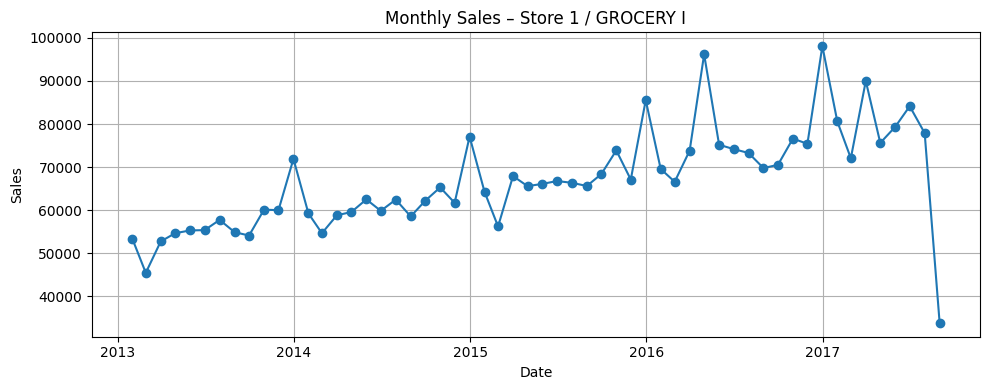

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(monthly["date"], monthly["sales"], marker="o")
plt.title(f"Monthly Sales – Store {focus_store} / {focus_family}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

STEP 2: Prepare the Data for Prophet

In [12]:
df_prophet = monthly.rename(columns={"date": "ds", "sales": "y"})
df_prophet.head()

,ds,y
0,2013-01-31,53397.0
1,2013-02-28,45447.0
2,2013-03-31,52736.0
3,2013-04-30,54654.0
4,2013-05-31,55290.0


Import and Fit Prophet

In [14]:
from prophet import Prophet

model = Prophet()
model.fit(df_prophet)

14:40:25 - cmdstanpy - INFO - Chain [1] start processing
14:40:26 - cmdstanpy - INFO - Chain [1] done processing


Create Future Dates

In [15]:
future = model.make_future_dataframe(periods=6, freq="ME")
future.tail()

,ds
57,2017-10-31
58,2017-11-30
59,2017-12-31
60,2018-01-31
61,2018-02-28


Predict Future Sales

In [17]:
forecast = model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
57,2017-10-31,83453.394244,75557.898715,91599.195454
58,2017-11-30,81150.342935,73608.923218,89090.667824
59,2017-12-31,98147.527839,90866.628473,106020.823685
60,2018-01-31,82504.200340,75503.255724,90884.100190
61,2018-02-28,77320.788474,69531.121216,85303.023556


Forecast Plot

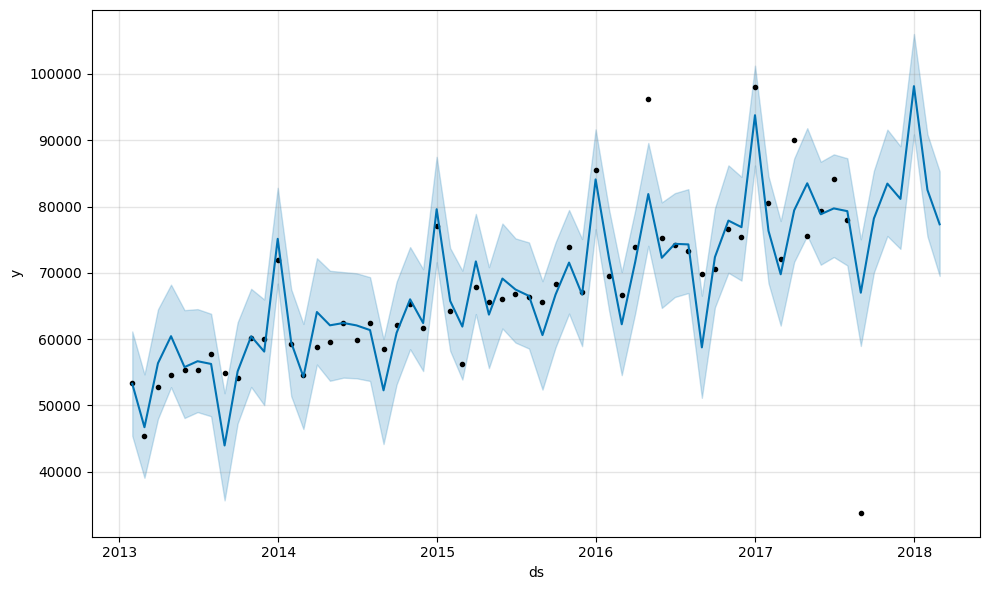

In [18]:
model.plot(forecast);


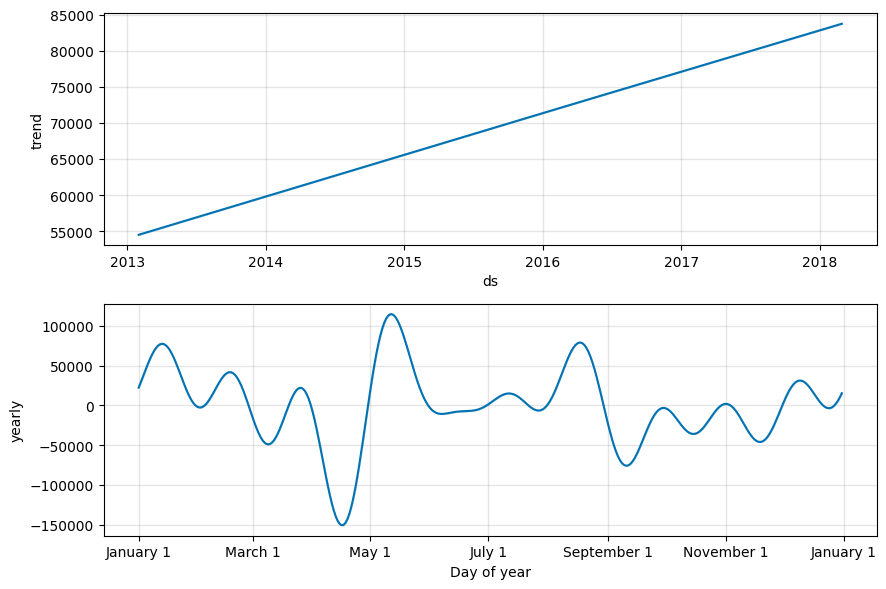

In [19]:
model.plot_components(forecast);

Merge Actual sales with Prophet output


In [20]:
pred = forecast[["ds", "yhat"]]
compare_df = pred.merge(df_prophet, on="ds", how="left") # y is actual
compare_df.head()

,ds,yhat,y
0,2013-01-31,53273.181698,53397.0
1,2013-02-28,46724.930910,45447.0
2,2013-03-31,56373.324462,52736.0
3,2013-04-30,60451.507606,54654.0
4,2013-05-31,55787.115974,55290.0


Plot Actual vs Forecast on the same chart

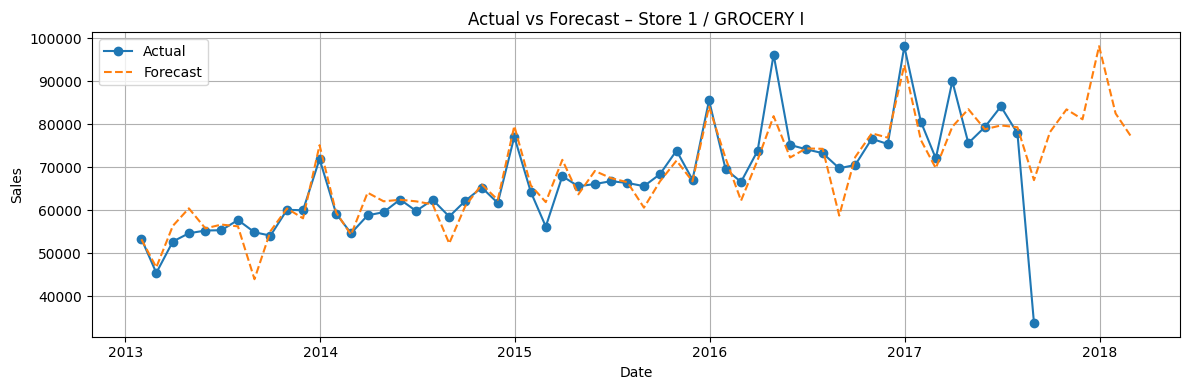

In [21]:
import matplotlib.pyplot as plt



plt.figure(figsize=(12,4))
plt.plot(compare_df["ds"], compare_df["y"],    label="Actual",   marker="o")
plt.plot(compare_df["ds"], compare_df["yhat"], label="Forecast", linestyle="--")
plt.title(f"Actual vs Forecast – Store {focus_store} / {focus_family}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Compute error metrics (MAE & MAPE)


In [22]:
from sklearn.metrics import mean_absolute_error
import numpy as np

mask = compare_df["y"].notna()      # only past months

mae  = mean_absolute_error(compare_df.loc[mask, "y"],
                           compare_df.loc[mask, "yhat"])

mape = np.mean(
        np.abs((compare_df.loc[mask, "y"] - compare_df.loc[mask, "yhat"])
        /      compare_df.loc[mask, "y"])) * 100

print(f"MAE  (all history): {mae:,.2f}")
print(f"MAPE (all history): {mape:.2f}%")


MAE  (all history): 3,468.27
MAPE (all history): 5.95%


Evaluate on the last 6 historical months only

In [23]:
cutoff = df_prophet["ds"].max() - pd.DateOffset(months=6)
val_mask = mask & (compare_df["ds"] > cutoff)

mae_val  = mean_absolute_error(compare_df.loc[val_mask, "y"],
                               compare_df.loc[val_mask, "yhat"])

print(f"MAE on last 6 months: {mae_val:,.2f}")


MAE on last 6 months: 9,663.54
